In [1]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy grad-cam

In [2]:
# Import libraries
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

# Grad-CAM imports
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
# Dataset paths for your PC
real_dataset_path = r"D:\Projects\dataset\real"
fake_dataset_path = r"D:\Projects\dataset\fake"

In [4]:
# List all image files (common formats)
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']

def get_image_files(path):
    files = []
    for ext in image_extensions:
        files.extend([os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(ext)])
    return files

real_images = get_image_files(real_dataset_path)
fake_images = get_image_files(fake_dataset_path)

print(f"Total real images found: {len(real_images)}")
print(f"Total fake images found: {len(fake_images)}")

Total real images found: 2000
Total fake images found: 2000


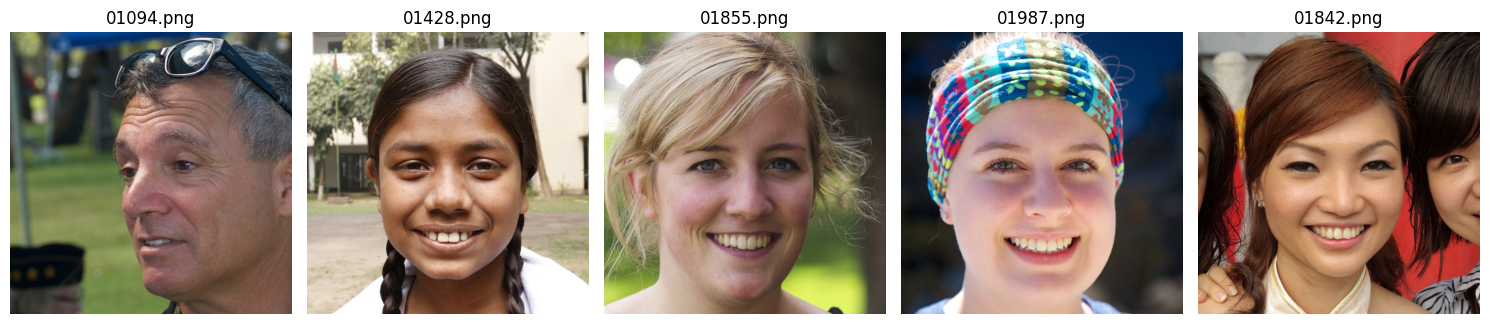

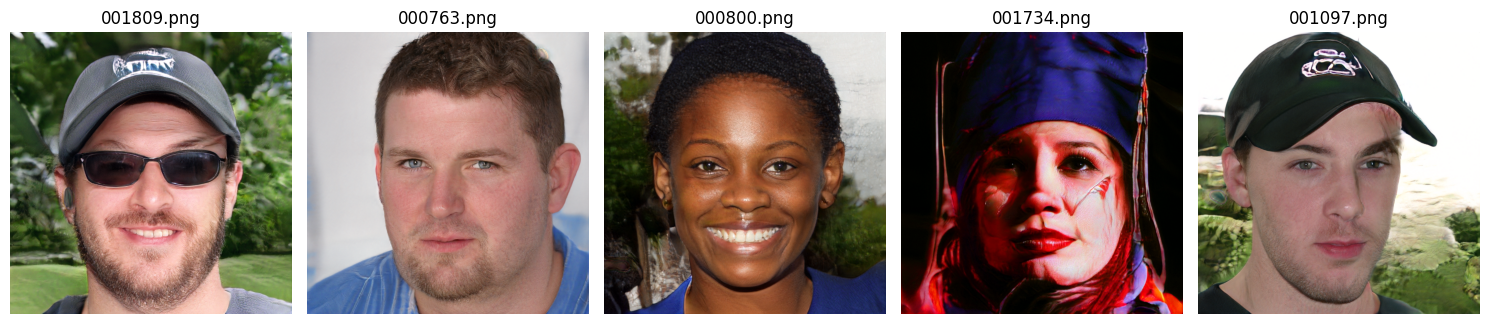

In [5]:
# Display 5 random real images
sample_real_images = random.sample(real_images, min(5, len(real_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_real_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

# Display 5 random fake images
sample_fake_images = random.sample(fake_images, min(5, len(fake_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_fake_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

In [6]:
# Define custom dataset for real and fake images
class DeepfakeDataset(Dataset):
    def __init__(self, real_images, fake_images, transform=None):
        self.real_images = real_images
        self.fake_images = fake_images
        self.transform = transform
        # Create image list and labels (0 for real, 1 for fake)
        self.all_images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)
        # List to store indices of valid images
        self.valid_indices = []
        self.corrupted_files = []

        # Check for valid images during initialization
        for idx in range(len(self.all_images)):
            try:
                img_path = self.all_images[idx]
                image = Image.open(img_path).convert('RGB')
                image.close()  # Close the image to free memory
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.all_images)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files ({len(self.corrupted_files)}): {self.corrupted_files}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map to valid index
        valid_idx = self.valid_indices[idx]
        img_path = self.all_images[valid_idx]
        label = self.labels[valid_idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # This should not happen due to pre-checking, but included as a safeguard
            print(f"Error loading image {img_path}: {e}")
            return None, None

In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [8]:
# Create dataset with balanced real images
dataset = DeepfakeDataset(real_images, fake_images, transform=transform)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders with custom collate function to handle None values
def custom_collate(batch):
    # Filter out None items
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

Total images: 4000
Valid images: 4000


In [11]:
# Define the ResNet-based classifier with Grad-CAM hooks
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)
        
        # Grad-CAM setup
        self.gradients = None
        self.features = None
        
        # Hook the feature maps and gradients
        target_layer = self.resnet.layer4[-1]  # Last convolutional layer
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)
        
        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def save_features(self, module, input, output):
        self.features = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\anaconda\envs\env\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/10], Train Loss: 0.7255, Train Acc: 55.72%, Val Loss: 4.6628, Val Acc: 53.75%
Epoch [2/10], Train Loss: 0.6073, Train Acc: 66.12%, Val Loss: 1.5161, Val Acc: 61.50%
Epoch [3/10], Train Loss: 0.4010, Train Acc: 82.00%, Val Loss: 0.4115, Val Acc: 79.88%
Epoch [4/10], Train Loss: 0.1774, Train Acc: 92.44%, Val Loss: 0.3674, Val Acc: 82.88%
Epoch [5/10], Train Loss: 0.0899, Train Acc: 96.47%, Val Loss: 0.1632, Val Acc: 94.12%
Epoch [6/10], Train Loss: 0.0474, Train Acc: 98.31%, Val Loss: 0.1120, Val Acc: 95.62%
Epoch [7/10], Train Loss: 0.0144, Train Acc: 99.53%, Val Loss: 0.1058, Val Acc: 96.62%
Epoch [8/10], Train Loss: 0.0360, Train Acc: 98.59%, Val Loss: 0.1907, Val Acc: 93.00%
Epoch [9/10], Train Loss: 0.0354, Train Acc: 98.78%, Val Loss: 0.3082, Val Acc: 91.50%
Epoch [10/10], Train Loss: 0.0183, Train Acc: 99.31%, Val Loss: 0.1431, Val Acc: 95.38%


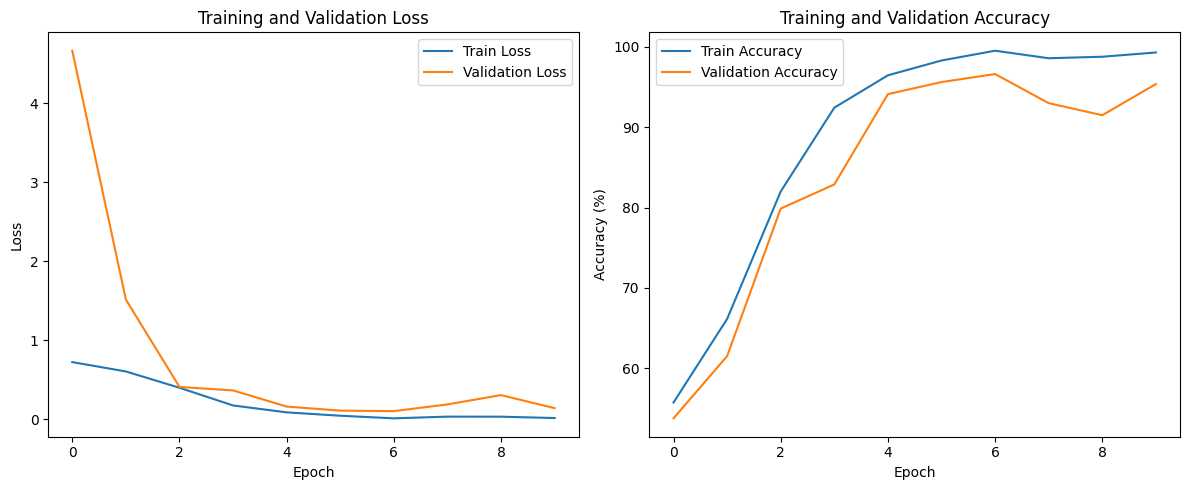

In [12]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_train += images.size(0)
        # Calculate training accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_train if total_train > 0 else float('inf')
    train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Skip empty batches
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total_val += images.size(0)
            # Calculate validation accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
    val_epoch_loss = val_loss / total_val if total_val > 0 else float('inf')
    val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [13]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 95.38%


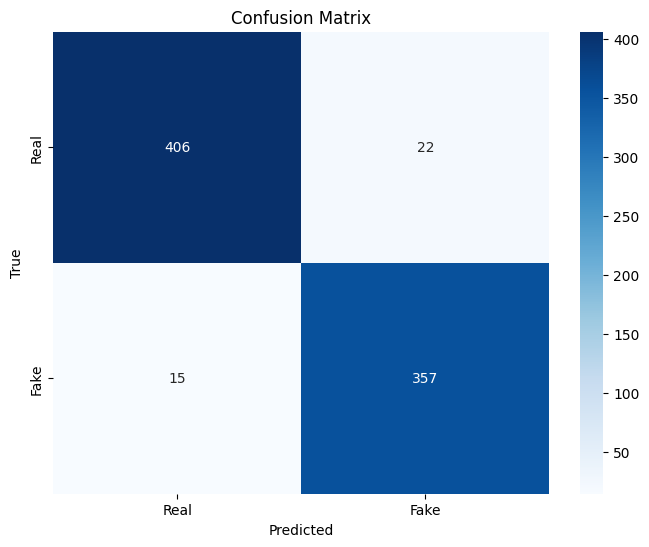

Confusion Matrix:
True Negatives (Real as Real): 406
False Positives (Real as Fake): 22
False Negatives (Fake as Real): 15
True Positives (Fake as Fake): 357


In [14]:
# Evaluate the model on the test set to compute confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float().squeeze().cpu().numpy()
        all_preds.extend(predicted)
        all_labels.extend(labels.squeeze().cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (Real as Real): {cm[0, 0]}")
print(f"False Positives (Real as Fake): {cm[0, 1]}")
print(f"False Negatives (Fake as Real): {cm[1, 0]}")
print(f"True Positives (Fake as Fake): {cm[1, 1]}")

In [26]:
# Grad-CAM implementation
def grad_cam(model, img_tensor, device):
    model.eval()
    
    # Reset gradients and features
    model.gradients = None
    model.features = None
    
    # Forward pass
    img_input = img_tensor.unsqueeze(0).to(device)
    img_input.requires_grad_(True)
    output = model(img_input)
    
    # Backward pass
    output.backward()
    
    # Get gradients and features
    gradients = model.gradients
    features = model.features
    
    if gradients is None or features is None:
        print("Warning: Gradients or features not captured!")
        return np.zeros((224, 224))
    
    # Pool the gradients across spatial dimensions to get channel importance
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Weight the feature maps by their importance
    weighted_features = features.clone()
    for i in range(features.size(1)):
        weighted_features[:, i, :, :] *= pooled_gradients[i]
    
    # Average across all channels to create heatmap
    heatmap = torch.mean(weighted_features, dim=1).squeeze()
    
    # Apply ReLU to keep only positive influences
    heatmap = torch.clamp(heatmap, min=0)
    
    # Convert to numpy and normalize
    heatmap_np = heatmap.cpu().detach().numpy()
    if heatmap_np.max() > 0:
        heatmap_np = heatmap_np / heatmap_np.max()
    
    return heatmap_np

In [24]:
# Create  overlay
def create_overlay(original_img, heatmap, alpha=0.4):
    # Ensure image is in correct format (0-1 range)
    if original_img.max() <= 1:
        img_display = (original_img * 255).astype(np.uint8)
    else:
        img_display = original_img.astype(np.uint8)
    
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    
    # Convert heatmap to colored version
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Method 1: Standard overlay (your original method)
    overlay_standard = heatmap_colored * alpha + img_display * (1 - alpha)
    overlay_standard = np.clip(overlay_standard, 0, 255).astype(np.uint8)
    
    # Method 2: Better overlay that preserves image details
    overlay_enhanced = cv2.addWeighted(img_display, 0.7, heatmap_colored, 0.3, 0)
    
    return {
        'standard': overlay_standard,
        'enhanced': overlay_enhanced,
        'heatmap_only': heatmap_colored,
        'heatmap_grayscale': heatmap_uint8
    }


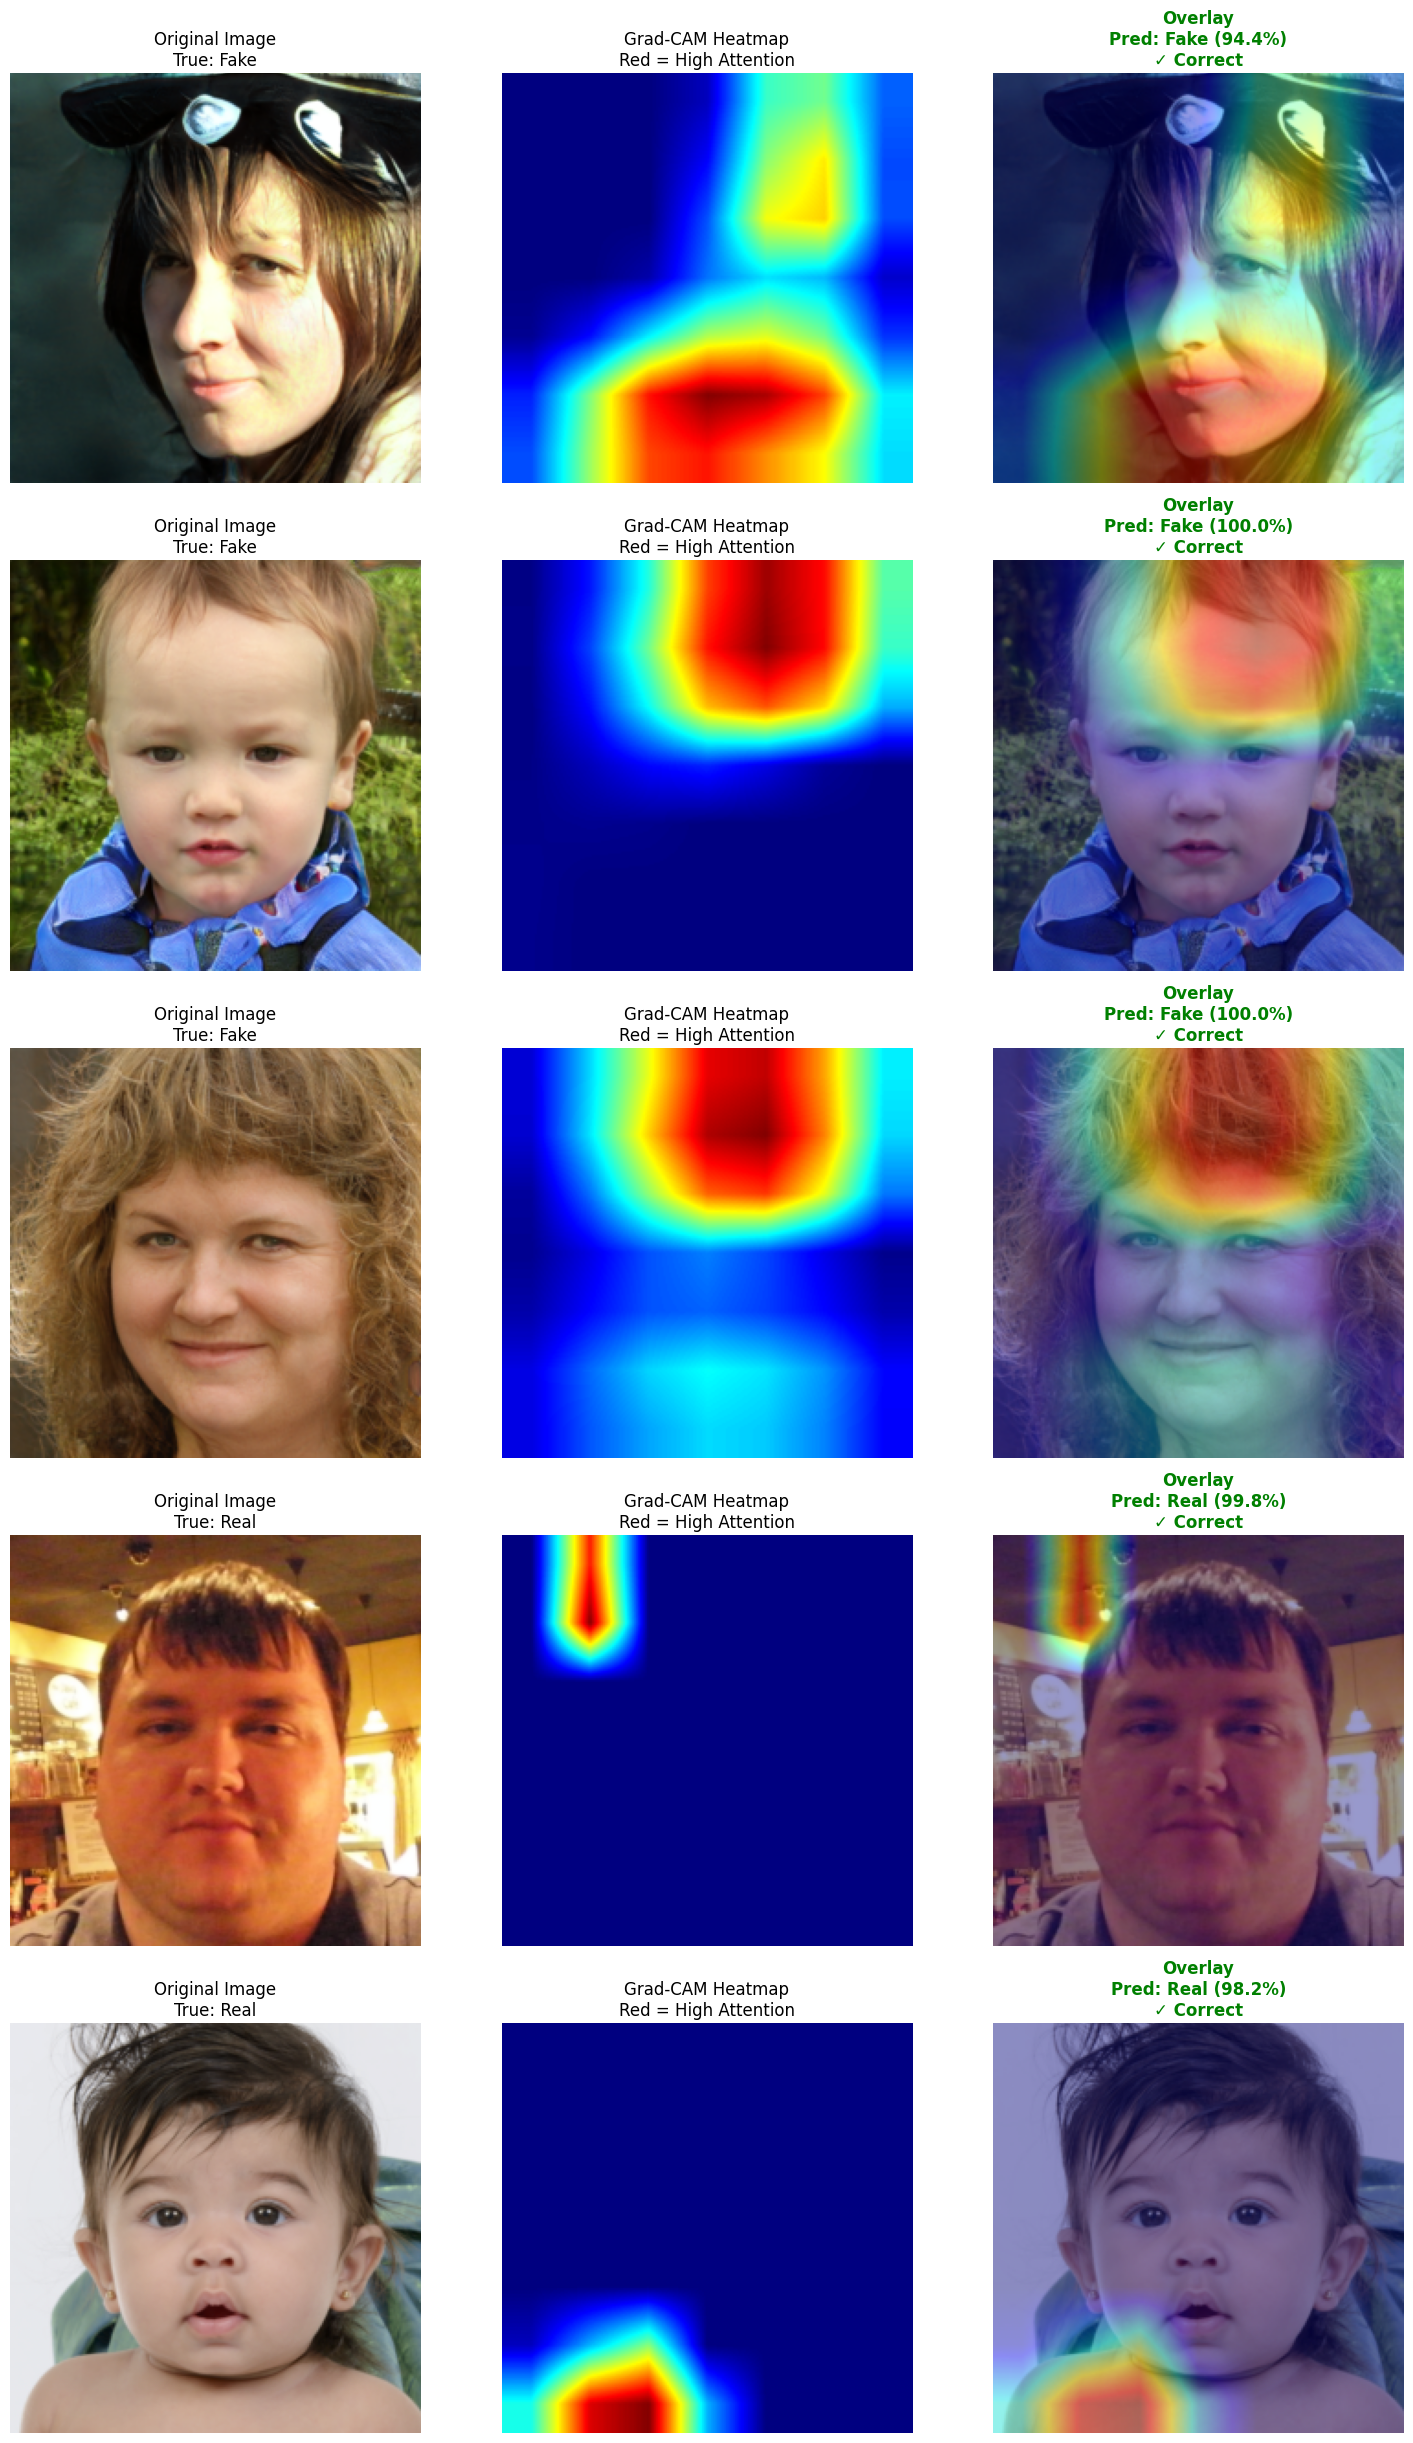

In [35]:
# Grad-CAM visualization
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

# Get predictions and confidence scores
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.sigmoid(outputs)
    predicted = (probabilities > 0.5).float()
    confidence = torch.where(probabilities > 0.5, probabilities, 1 - probabilities)

# Move to CPU for visualization
images = images.cpu()
labels = labels.cpu().squeeze()
predicted = predicted.cpu().squeeze()
probabilities = probabilities.cpu().squeeze()
confidence = confidence.cpu().squeeze()

# Create visualization (3 columns: Original, Heatmap, Overlay)
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Generate Grad-CAM heatmap
    heatmap = grad_cam(model, images[i], device)

    # Process original image (denormalize)
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Create overlay
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + img * 255 * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Prepare labels and predictions
    true_label = "Fake" if labels[i] else "Real"
    pred_label = "Fake" if predicted[i] else "Real"
    conf_score = confidence[i].item()
    is_correct = predicted[i] == labels[i]
    title_color = 'green' if is_correct else 'red'

    # Column 1: Original Image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original Image\nTrue: {true_label}', fontsize=12)
    axes[i, 0].axis('off')

    # Column 2: Grad-CAM Heatmap
    axes[i, 1].imshow(heatmap)
    axes[i, 1].set_title('Grad-CAM Heatmap\nRed = High Attention', fontsize=12)
    axes[i, 1].axis('off')

    # Column 3: Overlay with prediction info
    axes[i, 2].imshow(superimposed_img)
    pred_status = "✓ Correct" if is_correct else "✗ Incorrect"
    axes[i, 2].set_title(f'Overlay\nPred: {pred_label} ({conf_score:.1%})\n{pred_status}', 
                        color=title_color, fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [36]:
# Save the model
model_path = r"D:\Projects\models\resnet.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to D:\Projects\models\resnet.pth


In [42]:
class DeepfakeAnalyzer:
    def __init__(self, model_path):
        self.model = DeepfakeClassifier()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load model weights
        try:
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.eval()
            self.model.to(self.device)
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading model: {e}")
            self.model = None
        
        # Initialize transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def analyze_image(self, image):
        """Analyze image and return prediction with Grad-CAM visualization"""
        if self.model is None:
            return None, "Model not loaded properly", "", ""
        
        try:
            # Convert image to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Prepare image
            original_image_np = np.array(image) / 255.0
            input_tensor = self.transform(image).to(self.device)
            
            # Make prediction
            with torch.no_grad():
                output = self.model(input_tensor.unsqueeze(0))
                probability = torch.sigmoid(output).item()
                predicted_class = 1 if probability > 0.5 else 0
                confidence = probability if predicted_class == 1 else 1 - probability
            
            # Generate Grad-CAM using your function
            heatmap = grad_cam(self.model, input_tensor, self.device)
            
            # Resize heatmap to match original image dimensions
            heatmap = cv2.resize(heatmap, (image.width, image.height))
            heatmap = np.uint8(255 * heatmap)
            
            # Create heatmap visualization
            heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
            
            # Create overlay visualization
            overlay_img = cv2.addWeighted(
                (original_image_np * 255).astype(np.uint8), 0.6,
                heatmap_img, 0.4, 0
            )
            
            # Convert to PIL Images for Gradio
            overlay_pil = Image.fromarray(overlay_img)
            heatmap_pil = Image.fromarray(heatmap_img)
            
            prediction_text = f"Prediction: {'FAKE' if predicted_class == 1 else 'REAL'}"
            confidence_text = f"Confidence: {confidence:.1%}"
            probability_text = f"Fake Probability: {probability:.1%}"
            
            return overlay_pil, prediction_text, confidence_text, probability_text, heatmap_pil
            
        except Exception as e:
            return None, f"Error: {str(e)}", "", "", None

In [43]:
# Initialize analyzer
MODEL_PATH = r"D:\Projects\models\resnet.pth"
analyzer = DeepfakeAnalyzer(MODEL_PATH)

def gradio_analyze(image):
    if image is None:
        return None, "Please upload an image", "", "", None
    
    return analyzer.analyze_image(image)

# Create enhanced Gradio interface
def create_enhanced_gradio_interface():
    with gr.Blocks(title="Deepfake Detection with Explainable AI", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# 🔍 Explainable Deepfake Detection System")
        gr.Markdown("Upload an image to detect if it's real or AI-generated, with visual explanations of what the model focuses on.")
        
        with gr.Row():
            with gr.Column(scale=1):
                image_input = gr.Image(
                    type="pil",
                    label="Upload Image",
                    height=400
                )
                analyze_btn = gr.Button("🔍 Analyze Image", variant="primary", size="lg")
            
            with gr.Column(scale=2):
                with gr.Row():
                    with gr.Column():
                        prediction_output = gr.Textbox(
                            label="Prediction Result",
                            interactive=False
                        )
                        confidence_output = gr.Textbox(
                            label="Confidence Score",
                            interactive=False
                        )
                        probability_output = gr.Textbox(
                            label="Fake Probability",
                            interactive=False
                        )
                
                with gr.Row():
                    with gr.Column():
                        gradcam_output = gr.Image(
                            label="Grad-CAM Overlay - What the model focuses on",
                            height=300
                        )
                    with gr.Column():
                        heatmap_output = gr.Image(
                            label="Attention Heatmap - Red areas show high focus",
                            height=300
                        )
        
        gr.Markdown("""
        ### 🎯 How to interpret the visualizations:
        - **Grad-CAM Overlay**: Shows the original image with colored highlights indicating where the model focuses
        - **Attention Heatmap**: Pure heatmap where red/yellow areas indicate high model attention
        - **Red/Yellow areas**: Features the model considers important for its decision
        - **Blue/Dark areas**: Regions the model largely ignores
        
        ### 🧠 What the model typically focuses on:
        - **For Real faces**: Natural skin texture, lighting, facial features
        - **For Fake faces**: Artifacts, inconsistent lighting, unnatural smoothness, edge artifacts
        """)
        
        analyze_btn.click(
            fn=gradio_analyze,
            inputs=image_input,
            outputs=[gradcam_output, prediction_output, confidence_output, probability_output, heatmap_output]
        )
        
        # Auto-analyze when image is uploaded
        image_input.change(
            fn=gradio_analyze,
            inputs=image_input,
            outputs=[gradcam_output, prediction_output, confidence_output, probability_output, heatmap_output]
        )
    
    return demo

# Launch the enhanced interface
if __name__ == "__main__":
    demo = create_enhanced_gradio_interface()
    demo.launch(
        share=True,
        debug=True,
        server_name="0.0.0.0"
    )

Model loaded successfully!
* Running on local URL:  http://0.0.0.0:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


d:\anaconda\envs\env\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Keyboard interruption in main thread... closing server.
